<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/RFF-FCN_Brachial-Plexus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam,SGD
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O train.zip && rm -rf /tmp/cookies.txt


FILEID = "1mi69Hm_1L0ZfbtKaJbuzfymS3EubsKPy"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O test.zip && rm -rf /tmp/cookies.txt

--2021-08-18 17:06:42--  https://docs.google.com/uc?export=download&confirm=dNcJ&id=1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH
Resolving docs.google.com (docs.google.com)... 172.253.123.101, 172.253.123.100, 172.253.123.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.123.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-54-docs.googleusercontent.com/docs/securesc/rgeb9ohqqcdjp1ue7555gm5avd5g96vt/ba1et4lrp2c49jfnci9qn6ohb391mlin/1629306375000/05137136237839183901/12468030566917383044Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download [following]
--2021-08-18 17:06:42--  https://doc-0k-54-docs.googleusercontent.com/docs/securesc/rgeb9ohqqcdjp1ue7555gm5avd5g96vt/ba1et4lrp2c49jfnci9qn6ohb391mlin/1629306375000/05137136237839183901/12468030566917383044Z/1aWcmETxflatj1gtBGEvdw1PdIOw7YyJH?e=download
Resolving doc-0k-54-docs.googleusercontent.com (doc-0k-54-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Conne

In [ ]:
!mkdir train
!mkdir test
!unzip -q train.zip -d train
!unzip -q test.zip -d test

In [ ]:
files_path = glob('./train/*.tif')
files_path = [filepath_ for filepath_ in files_path if 'mask' not in filepath_]
files_mask = [files[:-4]+'_mask.tif' for files in files_path]

# files_path_test = glob('./test/*.tif')
# files_path_test = [filepath_ for filepath_ in files_path_test if 'mask' not in filepath_]
# files_mask_test = [files[:-4]+'_mask.tif' for files in files_path_test]

In [ ]:
void = [np.unique(cv2.imread(mask,cv2.IMREAD_GRAYSCALE)).size==2 for mask in files_mask]
print('All have nerve in train?: {}'.format(np.all(void)))

All have nerve in train?: False


In [ ]:
for_test_files,for_test_mask = [files for c,files in zip(void,files_path) if not(c)],[mask for c,mask in zip(void,files_mask) if not(c)]
files_path,files_mask = [files for c,files in zip(void,files_path) if c],[mask for c,mask in zip(void,files_mask) if c]

# df_train = pd.DataFrame({'filepath':files_path,'mask':files_mask})
# df_test_images = pd.DataFrame({'filepath':files_path_test + for_test_files,'mask':files_mask_test+for_test_mask})

### Split sets

In [ ]:
files_path,files_path_test,files_mask,files_mask_test = train_test_split(np.array(files_path),
                                                                         np.array(files_mask),
                                                                         test_size=0.2)
df_train = pd.DataFrame({'filepath':files_path.tolist(),'mask':files_mask.tolist()})
df_test_images = pd.DataFrame({'filepath':files_path_test.tolist(),
                               'mask':files_mask_test.tolist()})

In [ ]:
df_test_images

,filepath,mask
0,./train/41_34.tif,./train/41_34_mask.tif
1,./train/11_119.tif,./train/11_119_mask.tif
2,./train/7_95.tif,./train/7_95_mask.tif
3,./train/25_44.tif,./train/25_44_mask.tif
4,./train/42_25.tif,./train/42_25_mask.tif
...,...,...
460,./train/7_56.tif,./train/7_56_mask.tif
461,./train/15_19.tif,./train/15_19_mask.tif
462,./train/4_45.tif,./train/4_45_mask.tif
463,./train/23_41.tif,./train/23_41_mask.tif


In [ ]:
df_train_images,df_val_images = train_test_split(df_train, test_size=0.2)
# df_train_images,df_val_images = train_test_split(df_train_images, test_size=0.2)

In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1486 validated image filenames.
Found 1486 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.
Found 465 validated image filenames.
Found 465 validated image filenames.


Shape_in: (32, 128, 128, 3)


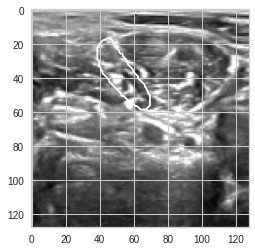

array([0., 1.], dtype=float32)

In [ ]:
i,j = next(test_gen)
print('Shape_in: {}'.format(i.shape))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()
np.unique(j[0,:,:,0])

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.layers.experimental import RandomFourierFeatures
GAUSSIAN_NOISE = 0.1
ACTIVATION = 'relu'
def fcn(image_size, phi_units,ch_in=3, ch_out=1):
    
    # inputs = Input(shape=(*image_size, ch_in), name='input')

    # # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    # vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # # Recovering the feature maps generated by each of the 3 final blocks:
    # f3 = vgg16.get_layer('block3_pool').output  
    # f4 = vgg16.get_layer('block4_pool').output  
    # f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:

    inputs = Input((*image_size, ch_in), name = 'RGB_Input')
    gn_inputs = GaussianNoise(GAUSSIAN_NOISE)(inputs)
    bn_inputs = BatchNormalization()(gn_inputs)
    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (bn_inputs)

    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)
    f1 = BatchNormalization()(f1)
    f1 = MaxPooling2D((2, 2)) (f1)

    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)#(inputs)
    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f2)
    f2 = BatchNormalization()(f2)
    f2 = MaxPooling2D((2, 2)) (f2)

    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f2)#(inputs)
    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f3 = BatchNormalization()(f3)
    f3 = MaxPooling2D((2, 2)) (f3)

    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f4 = BatchNormalization()(f4)
    f4 = MaxPooling2D((2, 2)) (f4)

    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f5)
    f5 = BatchNormalization()(f5)
    f5 = MaxPooling2D((2, 2)) (f5)


    #%% Modified by CAJ
    flatten = Flatten()(f5)
    rff = RandomFourierFeatures(output_dim=int(height/32)*int(width/32)*phi_units,trainable=True,name = 'Phi')(flatten)
    resha = Reshape((int(height/32),int(width/32),-1))(rff)
    # f6 = Conv2D(ch_out, (1, 1), activation=ACTIVATION, padding='same') (resha)
    #%% End modify
    
    # f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
    #                   activation='relu')(resha)#(f5)
    # f5_drop1 = Dropout(0.5)(f5_conv1)
    # f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
    #                   activation='relu')(f5_drop1)
    # f5_drop2 = Dropout(0.5)(f5_conv2)
    # f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
    #                   activation=None)(f5_drop2)
    

    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(resha)#(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1,f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=1, kernel_size=16, strides=8,
                              padding='same', activation='sigmoid',name='output')(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

seg_model = fcn((128,128),1)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 128, 128, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 3)  12          gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         batch_normalization[0][0]        
______________________________________________________________________________________________

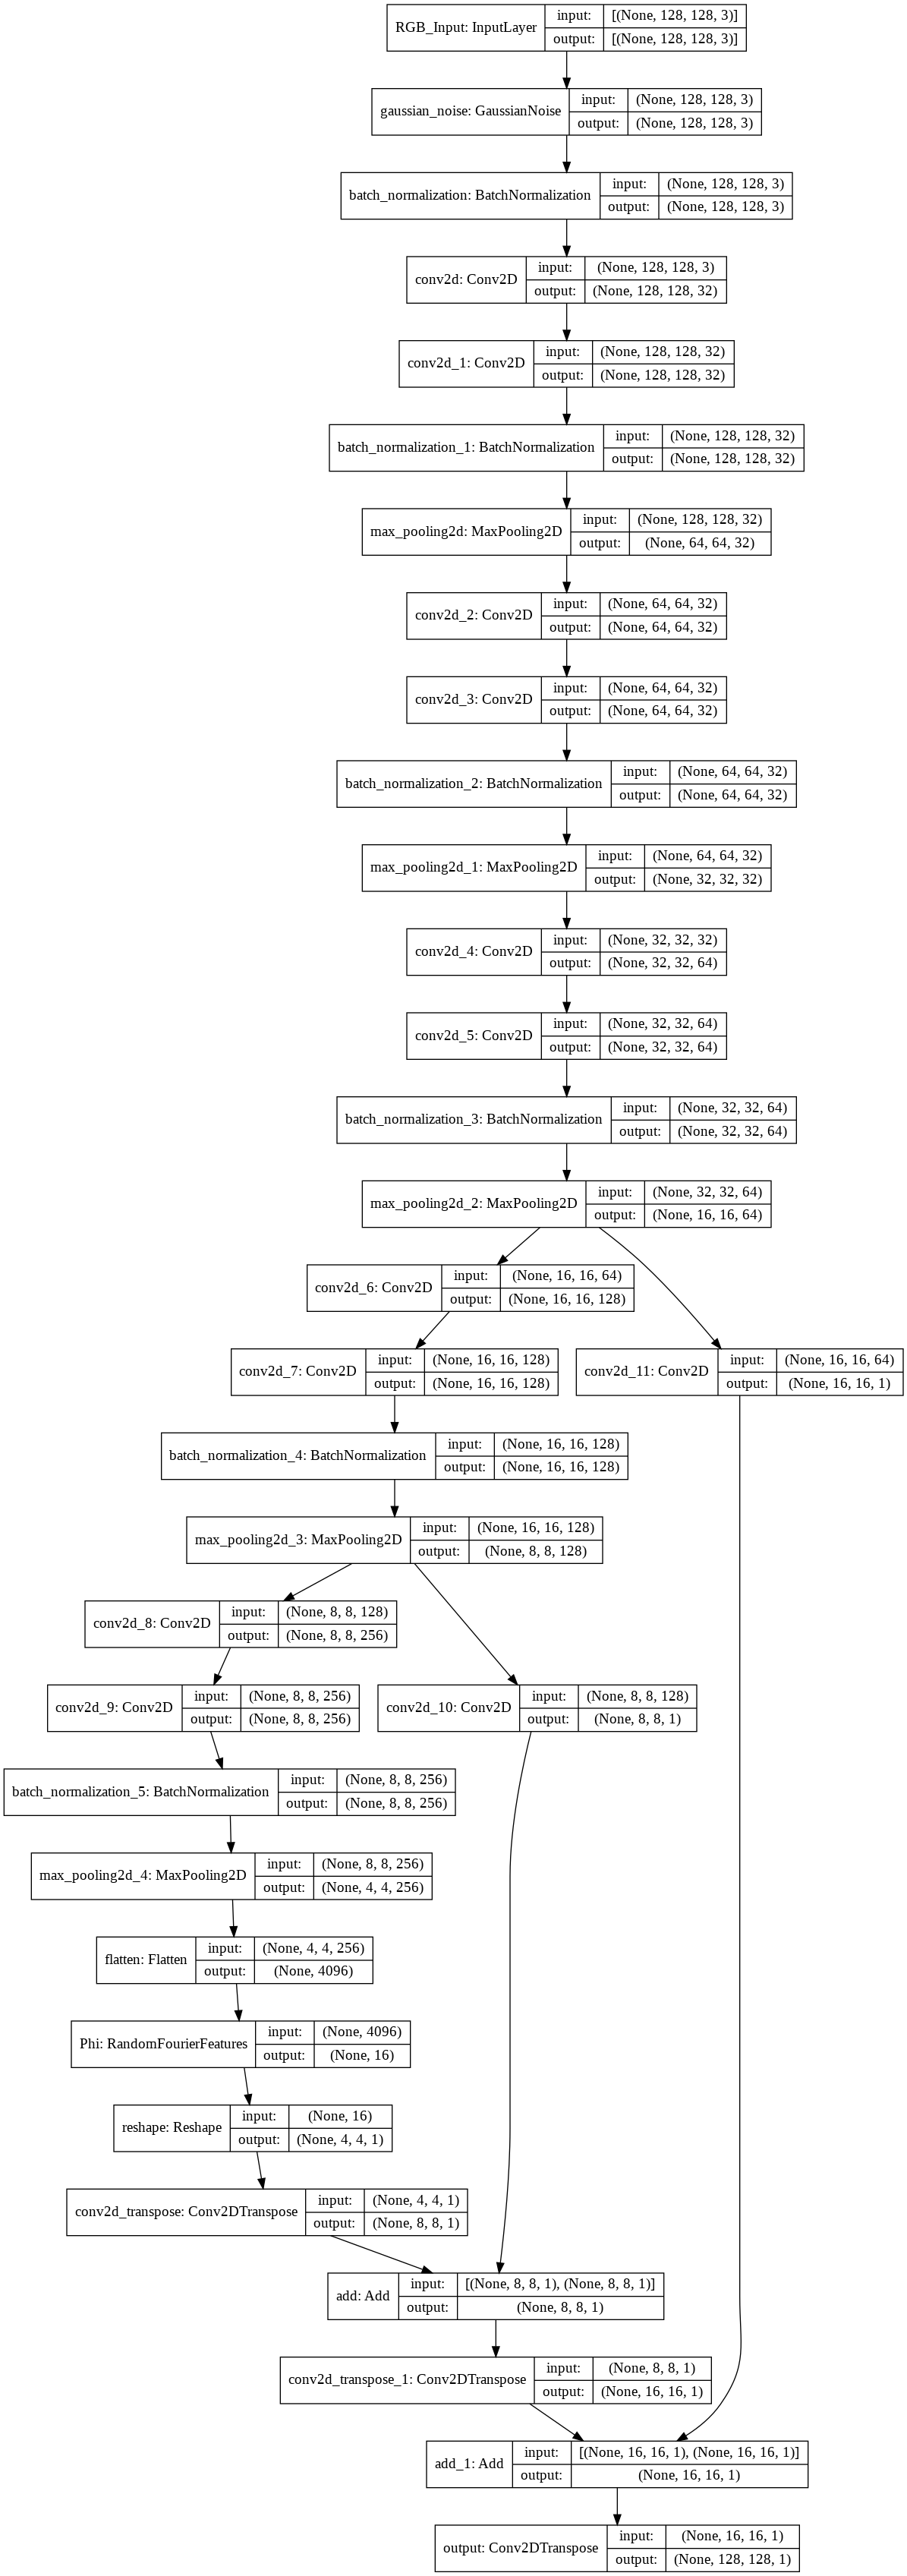

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
46/46 [==============================] - 38s 447ms/step - loss: -0.0661 - iou: 0.0342 - dice_coef: 0.0661 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4937 - val_loss: -0.0625 - val_iou: 0.0322 - val_dice_coef: 0.0625 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.6878


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 2/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 433ms/step - loss: -0.0831 - iou: 0.0432 - dice_coef: 0.0828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5675 - val_loss: -0.0613 - val_iou: 0.0316 - val_dice_coef: 0.0613 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8370


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 3/200
 1/46 [..............................] - ETA: 1s - loss: -0.0813 - iou: 0.0424 - dice_coef: 0.0813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6252

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.1060 - iou: 0.0559 - dice_coef: 0.1058 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.6809 - val_loss: -0.0603 - val_iou: 0.0311 - val_dice_coef: 0.0603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9105


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 4/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 439ms/step - loss: -0.1360 - iou: 0.0731 - dice_coef: 0.1360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7755 - val_loss: -0.0583 - val_iou: 0.0300 - val_dice_coef: 0.0583 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9458


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 5/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 443ms/step - loss: -0.1828 - iou: 0.1007 - dice_coef: 0.1827 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8638 - val_loss: -0.0533 - val_iou: 0.0274 - val_dice_coef: 0.0533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9649


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 6/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 441ms/step - loss: -0.2598 - iou: 0.1496 - dice_coef: 0.2594 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9303 - val_loss: -0.0409 - val_iou: 0.0209 - val_dice_coef: 0.0409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 7/200
 1/46 [..............................] - ETA: 1s - loss: -0.1237 - iou: 0.0659 - dice_coef: 0.1237 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9279

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.3707 - iou: 0.2286 - dice_coef: 0.3705 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9590 - val_loss: -0.0251 - val_iou: 0.0127 - val_dice_coef: 0.0251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9666


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 8/200
 1/46 [..............................] - ETA: 1s - loss: -0.1252 - iou: 0.0668 - dice_coef: 0.1252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9378

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.4758 - iou: 0.3138 - dice_coef: 0.4755 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9699 - val_loss: -0.0238 - val_iou: 0.0120 - val_dice_coef: 0.0238 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9669


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 9/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.5362 - iou: 0.3682 - dice_coef: 0.5358 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9726 - val_loss: -0.0867 - val_iou: 0.0455 - val_dice_coef: 0.0867 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9678


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 10/200
 1/46 [..............................] - ETA: 1s - loss: -0.1818 - iou: 0.1000 - dice_coef: 0.1818 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9479

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 441ms/step - loss: -0.5761 - iou: 0.4065 - dice_coef: 0.5757 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.1430 - val_iou: 0.0781 - val_dice_coef: 0.1430 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9688


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 11/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 446ms/step - loss: -0.6111 - iou: 0.4429 - dice_coef: 0.6115 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9767 - val_loss: -0.3524 - val_iou: 0.2146 - val_dice_coef: 0.3524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 12/200
 1/46 [..............................] - ETA: 1s - loss: -0.2645 - iou: 0.1524 - dice_coef: 0.2645 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9520

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.6207 - iou: 0.4524 - dice_coef: 0.6207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -0.4715 - val_iou: 0.3102 - val_dice_coef: 0.4715 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9751


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 13/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.6418 - iou: 0.4754 - dice_coef: 0.6418 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.4584 - val_iou: 0.3034 - val_dice_coef: 0.4584 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9745


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 14/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.6499 - iou: 0.4848 - dice_coef: 0.6501 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9787 - val_loss: -0.5147 - val_iou: 0.3486 - val_dice_coef: 0.5147 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 15/200
 1/46 [..............................] - ETA: 1s - loss: -0.3454 - iou: 0.2087 - dice_coef: 0.3454 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9581

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 442ms/step - loss: -0.6622 - iou: 0.4973 - dice_coef: 0.6625 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9793 - val_loss: -0.5635 - val_iou: 0.3961 - val_dice_coef: 0.5635 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 16/200
 1/46 [..............................] - ETA: 1s - loss: -0.3110 - iou: 0.1842 - dice_coef: 0.3110 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9545

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.6732 - iou: 0.5098 - dice_coef: 0.6732 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9799 - val_loss: -0.6054 - val_iou: 0.4386 - val_dice_coef: 0.6054 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 17/200
 1/46 [..............................] - ETA: 1s - loss: -0.3139 - iou: 0.1862 - dice_coef: 0.3139 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9551

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 440ms/step - loss: -0.6767 - iou: 0.5143 - dice_coef: 0.6770 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -0.6045 - val_iou: 0.4398 - val_dice_coef: 0.6045 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 18/200
 1/46 [..............................] - ETA: 1s - loss: -0.2135 - iou: 0.1195 - dice_coef: 0.2135 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9515

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 435ms/step - loss: -0.6814 - iou: 0.5212 - dice_coef: 0.6819 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.6324 - val_iou: 0.4671 - val_dice_coef: 0.6324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 19/200
 1/46 [..............................] - ETA: 1s - loss: -0.1506 - iou: 0.0815 - dice_coef: 0.1506 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9465

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.6831 - iou: 0.5228 - dice_coef: 0.6826 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.6333 - val_iou: 0.4657 - val_dice_coef: 0.6333 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 20/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.6930 - iou: 0.5335 - dice_coef: 0.6929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.6223 - val_iou: 0.4569 - val_dice_coef: 0.6223 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 21/200
 1/46 [..............................] - ETA: 1s - loss: -0.2004 - iou: 0.1113 - dice_coef: 0.2004 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9452

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 431ms/step - loss: -0.7009 - iou: 0.5448 - dice_coef: 0.7016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.6697 - val_iou: 0.5067 - val_dice_coef: 0.6697 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 22/200
 1/46 [..............................] - ETA: 1s - loss: -0.2468 - iou: 0.1408 - dice_coef: 0.2468 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9478

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.7032 - iou: 0.5460 - dice_coef: 0.7032 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9814 - val_loss: -0.6366 - val_iou: 0.4830 - val_dice_coef: 0.6366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9780


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 23/200
 1/46 [..............................] - ETA: 1s - loss: -0.2070 - iou: 0.1155 - dice_coef: 0.2070 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9485

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 432ms/step - loss: -0.7069 - iou: 0.5502 - dice_coef: 0.7065 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.6679 - val_iou: 0.5062 - val_dice_coef: 0.6679 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9797


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 24/200
 1/46 [..............................] - ETA: 1s - loss: -0.1662 - iou: 0.0907 - dice_coef: 0.1662 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9430

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.7064 - iou: 0.5508 - dice_coef: 0.7063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9818 - val_loss: -0.6481 - val_iou: 0.4880 - val_dice_coef: 0.6481 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 25/200
 1/46 [..............................] - ETA: 1s - loss: -0.2272 - iou: 0.1282 - dice_coef: 0.2272 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9517

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 430ms/step - loss: -0.7148 - iou: 0.5616 - dice_coef: 0.7157 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.6758 - val_iou: 0.5149 - val_dice_coef: 0.6758 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 26/200
 1/46 [..............................] - ETA: 1s - loss: -0.2186 - iou: 0.1227 - dice_coef: 0.2186 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9503

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.7204 - iou: 0.5672 - dice_coef: 0.7202 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9826 - val_loss: -0.6763 - val_iou: 0.5179 - val_dice_coef: 0.6763 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 27/200
 1/46 [..............................] - ETA: 1s - loss: -0.2525 - iou: 0.1445 - dice_coef: 0.2525 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9526

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 430ms/step - loss: -0.7187 - iou: 0.5654 - dice_coef: 0.7191 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.6683 - val_iou: 0.5095 - val_dice_coef: 0.6683 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 28/200
 1/46 [..............................] - ETA: 1s - loss: -0.2380 - iou: 0.1351 - dice_coef: 0.2380 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9547

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.7274 - iou: 0.5762 - dice_coef: 0.7278 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.6871 - val_iou: 0.5264 - val_dice_coef: 0.6871 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 29/200
 1/46 [..............................] - ETA: 1s - loss: -0.2386 - iou: 0.1355 - dice_coef: 0.2386 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9509

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.7240 - iou: 0.5712 - dice_coef: 0.7236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.6974 - val_iou: 0.5364 - val_dice_coef: 0.6974 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 30/200
 1/46 [..............................] - ETA: 1s - loss: -0.2340 - iou: 0.1325 - dice_coef: 0.2340 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9493

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 421ms/step - loss: -0.7312 - iou: 0.5805 - dice_coef: 0.7310 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.6584 - val_iou: 0.5039 - val_dice_coef: 0.6584 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 31/200
 1/46 [..............................] - ETA: 1s - loss: -0.3116 - iou: 0.1846 - dice_coef: 0.3116 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9554

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7341 - iou: 0.5826 - dice_coef: 0.7334 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.6578 - val_iou: 0.5033 - val_dice_coef: 0.6578 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 32/200
 1/46 [..............................] - ETA: 1s - loss: -0.2895 - iou: 0.1692 - dice_coef: 0.2895 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9540

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.7315 - iou: 0.5810 - dice_coef: 0.7320 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.6760 - val_iou: 0.5239 - val_dice_coef: 0.6760 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 33/200
 1/46 [..............................] - ETA: 1s - loss: -0.1808 - iou: 0.0994 - dice_coef: 0.1808 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9479

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 420ms/step - loss: -0.7387 - iou: 0.5920 - dice_coef: 0.7394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.7006 - val_iou: 0.5420 - val_dice_coef: 0.7006 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 34/200
 1/46 [..............................] - ETA: 1s - loss: -0.2411 - iou: 0.1371 - dice_coef: 0.2411 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9497

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.7347 - iou: 0.5849 - dice_coef: 0.7345 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.7120 - val_iou: 0.5542 - val_dice_coef: 0.7120 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 35/200
 1/46 [..............................] - ETA: 1s - loss: -0.2418 - iou: 0.1375 - dice_coef: 0.2418 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9492

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.7435 - iou: 0.5968 - dice_coef: 0.7438 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6725 - val_iou: 0.5184 - val_dice_coef: 0.6725 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/200
46/46 [==============================] - 19s 429ms/step - loss: -0.7437 - iou: 0.5974 - dice_coef: 0.7435 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9840 - val_loss: -0.6770 - val_iou: 0.5263 - val_dice_coef: 0.6770 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 37/200
 1/46 [..............................] - ETA: 1s - loss: -0.2024 - iou: 0.1126 - dice_coef: 0.2024 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9490

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.7381 - iou: 0.5895 - dice_coef: 0.7376 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9835 - val_loss: -0.7086 - val_iou: 0.5515 - val_dice_coef: 0.7086 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 38/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 420ms/step - loss: -0.7478 - iou: 0.6015 - dice_coef: 0.7477 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.7093 - val_iou: 0.5531 - val_dice_coef: 0.7093 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 39/200
 1/46 [..............................] - ETA: 1s - loss: -0.2508 - iou: 0.1434 - dice_coef: 0.2508 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9497

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 430ms/step - loss: -0.7499 - iou: 0.6039 - dice_coef: 0.7494 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.7010 - val_iou: 0.5445 - val_dice_coef: 0.7010 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 40/200
 1/46 [..............................] - ETA: 1s - loss: -0.2980 - iou: 0.1751 - dice_coef: 0.2980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9539

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7536 - iou: 0.6084 - dice_coef: 0.7535 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.7162 - val_iou: 0.5611 - val_dice_coef: 0.7162 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 41/200
 1/46 [..............................] - ETA: 1s - loss: -0.3470 - iou: 0.2100 - dice_coef: 0.3470 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9573

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.7560 - iou: 0.6107 - dice_coef: 0.7556 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.6786 - val_iou: 0.5319 - val_dice_coef: 0.6786 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 42/200
 1/46 [..............................] - ETA: 1s - loss: -0.2951 - iou: 0.1731 - dice_coef: 0.2951 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9586

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.7546 - iou: 0.6099 - dice_coef: 0.7545 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7238 - val_iou: 0.5722 - val_dice_coef: 0.7238 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 43/200
 1/46 [..............................] - ETA: 1s - loss: -0.3555 - iou: 0.2162 - dice_coef: 0.3555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9573

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.7586 - iou: 0.6144 - dice_coef: 0.7586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.6956 - val_iou: 0.5457 - val_dice_coef: 0.6956 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 44/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.7572 - iou: 0.6137 - dice_coef: 0.7571 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9847 - val_loss: -0.7063 - val_iou: 0.5518 - val_dice_coef: 0.7063 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 45/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.7578 - iou: 0.6137 - dice_coef: 0.7576 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7051 - val_iou: 0.5558 - val_dice_coef: 0.7051 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/200
46/46 [==============================] - 19s 425ms/step - loss: -0.7634 - iou: 0.6216 - dice_coef: 0.7634 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.7166 - val_iou: 0.5641 - val_dice_coef: 0.7166 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9815


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 47/200
 1/46 [..............................] - ETA: 1s - loss: -0.1945 - iou: 0.1077 - dice_coef: 0.1945 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9458

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7616 - iou: 0.6209 - dice_coef: 0.7618 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.7251 - val_iou: 0.5716 - val_dice_coef: 0.7251 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 48/200
 1/46 [..............................] - ETA: 1s - loss: -0.2821 - iou: 0.1642 - dice_coef: 0.2821 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9528

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 432ms/step - loss: -0.7641 - iou: 0.6226 - dice_coef: 0.7641 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.6873 - val_iou: 0.5419 - val_dice_coef: 0.6873 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9805


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 49/200
 1/46 [..............................] - ETA: 0s - loss: -0.4002 - iou: 0.2502 - dice_coef: 0.4002 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9580

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7733 - iou: 0.6273 - dice_coef: 0.7688 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7273 - val_iou: 0.5753 - val_dice_coef: 0.7273 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 50/200
 1/46 [..............................] - ETA: 1s - loss: -0.2872 - iou: 0.1677 - dice_coef: 0.2872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9527

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 422ms/step - loss: -0.7690 - iou: 0.6291 - dice_coef: 0.7690 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7163 - val_iou: 0.5653 - val_dice_coef: 0.7163 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 51/200
 1/46 [..............................] - ETA: 1s - loss: -0.2949 - iou: 0.1730 - dice_coef: 0.2949 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9555

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 456ms/step - loss: -0.7678 - iou: 0.6281 - dice_coef: 0.7683 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7312 - val_iou: 0.5786 - val_dice_coef: 0.7312 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 52/200
 1/46 [..............................] - ETA: 1s - loss: -0.2198 - iou: 0.1235 - dice_coef: 0.2198 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9493

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.7666 - iou: 0.6274 - dice_coef: 0.7669 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.7313 - val_iou: 0.5815 - val_dice_coef: 0.7313 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 53/200
 1/46 [..............................] - ETA: 1s - loss: -0.2780 - iou: 0.1614 - dice_coef: 0.2780 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9517

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 430ms/step - loss: -0.7726 - iou: 0.6342 - dice_coef: 0.7726 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7023 - val_iou: 0.5527 - val_dice_coef: 0.7023 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 54/200
 1/46 [..............................] - ETA: 1s - loss: -0.2791 - iou: 0.1622 - dice_coef: 0.2791 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9536

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.7706 - iou: 0.6317 - dice_coef: 0.7709 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.7113 - val_iou: 0.5621 - val_dice_coef: 0.7113 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 55/200
 1/46 [..............................] - ETA: 1s - loss: -0.3199 - iou: 0.1904 - dice_coef: 0.3199 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9528

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7734 - iou: 0.6348 - dice_coef: 0.7734 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7078 - val_iou: 0.5622 - val_dice_coef: 0.7078 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 56/200
 1/46 [..............................] - ETA: 1s - loss: -0.2841 - iou: 0.1656 - dice_coef: 0.2841 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9509

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7746 - iou: 0.6373 - dice_coef: 0.7750 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7082 - val_iou: 0.5602 - val_dice_coef: 0.7082 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 57/200
 1/46 [..............................] - ETA: 1s - loss: -0.1846 - iou: 0.1017 - dice_coef: 0.1846 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9481

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7719 - iou: 0.6352 - dice_coef: 0.7724 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.7289 - val_iou: 0.5779 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 58/200
 1/46 [..............................] - ETA: 1s - loss: -0.2658 - iou: 0.1533 - dice_coef: 0.2658 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9482

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.7786 - iou: 0.6430 - dice_coef: 0.7789 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.7283 - val_iou: 0.5776 - val_dice_coef: 0.7283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 59/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.7774 - iou: 0.6404 - dice_coef: 0.7773 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7377 - val_iou: 0.5861 - val_dice_coef: 0.7377 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 60/200
 1/46 [..............................] - ETA: 1s - loss: -0.3293 - iou: 0.1971 - dice_coef: 0.3293 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9557

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.7809 - iou: 0.6452 - dice_coef: 0.7813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7284 - val_iou: 0.5782 - val_dice_coef: 0.7284 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 61/200
 1/46 [..............................] - ETA: 1s - loss: -0.2992 - iou: 0.1760 - dice_coef: 0.2992 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9547

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.7780 - iou: 0.6420 - dice_coef: 0.7785 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.7283 - val_iou: 0.5770 - val_dice_coef: 0.7283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 62/200
 1/46 [..............................] - ETA: 1s - loss: -0.2741 - iou: 0.1588 - dice_coef: 0.2741 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9521

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 422ms/step - loss: -0.7817 - iou: 0.6470 - dice_coef: 0.7819 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7346 - val_iou: 0.5869 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 63/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 430ms/step - loss: -0.7834 - iou: 0.6487 - dice_coef: 0.7837 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7248 - val_iou: 0.5801 - val_dice_coef: 0.7248 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 64/200
 1/46 [..............................] - ETA: 1s - loss: -0.3256 - iou: 0.1945 - dice_coef: 0.3256 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9559

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 429ms/step - loss: -0.7838 - iou: 0.6487 - dice_coef: 0.7839 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9864 - val_loss: -0.7291 - val_iou: 0.5783 - val_dice_coef: 0.7291 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 65/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.7828 - iou: 0.6468 - dice_coef: 0.7828 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7446 - val_iou: 0.5973 - val_dice_coef: 0.7446 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 66/200
 1/46 [..............................] - ETA: 1s - loss: -0.2207 - iou: 0.1240 - dice_coef: 0.2207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9481

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.7837 - iou: 0.6506 - dice_coef: 0.7841 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.7330 - val_iou: 0.5828 - val_dice_coef: 0.7330 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 67/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.7822 - iou: 0.6483 - dice_coef: 0.7825 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.7474 - val_iou: 0.6004 - val_dice_coef: 0.7474 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 68/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.7873 - iou: 0.6541 - dice_coef: 0.7873 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7346 - val_iou: 0.5908 - val_dice_coef: 0.7346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 69/200
 1/46 [..............................] - ETA: 1s - loss: -0.3805 - iou: 0.2350 - dice_coef: 0.3805 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9615

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.7897 - iou: 0.6566 - dice_coef: 0.7901 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7469 - val_iou: 0.6003 - val_dice_coef: 0.7469 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 70/200
 1/46 [..............................] - ETA: 1s - loss: -0.1864 - iou: 0.1028 - dice_coef: 0.1864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9434

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 435ms/step - loss: -0.7867 - iou: 0.6549 - dice_coef: 0.7866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.7418 - val_iou: 0.5933 - val_dice_coef: 0.7418 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 71/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.7916 - iou: 0.6588 - dice_coef: 0.7913 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7450 - val_iou: 0.5983 - val_dice_coef: 0.7450 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 72/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 439ms/step - loss: -0.7882 - iou: 0.6545 - dice_coef: 0.7877 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7409 - val_iou: 0.5930 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 73/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.7899 - iou: 0.6576 - dice_coef: 0.7895 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7324 - val_iou: 0.5831 - val_dice_coef: 0.7324 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 74/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 434ms/step - loss: -0.7897 - iou: 0.6591 - dice_coef: 0.7903 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.7177 - val_iou: 0.5735 - val_dice_coef: 0.7177 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 75/200
 1/46 [..............................] - ETA: 1s - loss: -0.2377 - iou: 0.1349 - dice_coef: 0.2377 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9499

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 435ms/step - loss: -0.7902 - iou: 0.6591 - dice_coef: 0.7904 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7448 - val_iou: 0.6008 - val_dice_coef: 0.7448 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 76/200
 1/46 [..............................] - ETA: 1s - loss: -0.3002 - iou: 0.1766 - dice_coef: 0.3002 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9568

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 435ms/step - loss: -0.8002 - iou: 0.6723 - dice_coef: 0.8005 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7497 - val_iou: 0.6039 - val_dice_coef: 0.7497 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 77/200
 1/46 [..............................] - ETA: 1s - loss: -0.2742 - iou: 0.1589 - dice_coef: 0.2742 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9502

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 439ms/step - loss: -0.7897 - iou: 0.6584 - dice_coef: 0.7902 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7427 - val_iou: 0.5942 - val_dice_coef: 0.7427 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 78/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.7929 - iou: 0.6629 - dice_coef: 0.7929 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.7422 - val_iou: 0.5946 - val_dice_coef: 0.7422 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 79/200
 1/46 [..............................] - ETA: 1s - loss: -0.1305 - iou: 0.0698 - dice_coef: 0.1305 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9441

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.7941 - iou: 0.6663 - dice_coef: 0.7942 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7413 - val_iou: 0.5944 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 80/200
 1/46 [..............................] - ETA: 1s - loss: -0.3008 - iou: 0.1770 - dice_coef: 0.3008 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9557

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 434ms/step - loss: -0.7981 - iou: 0.6697 - dice_coef: 0.7987 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7207 - val_iou: 0.5827 - val_dice_coef: 0.7207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 81/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 433ms/step - loss: -0.7916 - iou: 0.6600 - dice_coef: 0.7911 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.7492 - val_iou: 0.6030 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 82/200
 1/46 [..............................] - ETA: 1s - loss: -0.2637 - iou: 0.1519 - dice_coef: 0.2637 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9499

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 441ms/step - loss: -0.7985 - iou: 0.6707 - dice_coef: 0.7989 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7463 - val_iou: 0.5997 - val_dice_coef: 0.7463 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 83/200
46/46 [==============================] - 19s 433ms/step - loss: -0.7996 - iou: 0.6711 - dice_coef: 0.7997 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.7173 - val_iou: 0.5803 - val_dice_coef: 0.7173 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 84/200
 1/46 [..............................] - ETA: 1s - loss: -0.2238 - iou: 0.1260 - dice_coef: 0.2238 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9490

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 435ms/step - loss: -0.7971 - iou: 0.6693 - dice_coef: 0.7974 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.7356 - val_iou: 0.5939 - val_dice_coef: 0.7356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 85/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.7943 - iou: 0.6640 - dice_coef: 0.7941 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.7231 - val_iou: 0.5822 - val_dice_coef: 0.7231 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 86/200
 1/46 [..............................] - ETA: 1s - loss: -0.2891 - iou: 0.1690 - dice_coef: 0.2891 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9526

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.8022 - iou: 0.6747 - dice_coef: 0.8020 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7475 - val_iou: 0.6015 - val_dice_coef: 0.7475 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 87/200
 1/46 [..............................] - ETA: 1s - loss: -0.2341 - iou: 0.1326 - dice_coef: 0.2341 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9496

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 439ms/step - loss: -0.8013 - iou: 0.6745 - dice_coef: 0.8013 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7284 - val_iou: 0.5884 - val_dice_coef: 0.7284 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 88/200
 1/46 [..............................] - ETA: 1s - loss: -0.1404 - iou: 0.0755 - dice_coef: 0.1404 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9433

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 432ms/step - loss: -0.7975 - iou: 0.6716 - dice_coef: 0.7980 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.7176 - val_iou: 0.5777 - val_dice_coef: 0.7176 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9812


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 89/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 440ms/step - loss: -0.8073 - iou: 0.6796 - dice_coef: 0.8074 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7533 - val_iou: 0.6110 - val_dice_coef: 0.7533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 90/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.8029 - iou: 0.6768 - dice_coef: 0.8033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.7326 - val_iou: 0.5933 - val_dice_coef: 0.7326 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 91/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8063 - iou: 0.6793 - dice_coef: 0.8063 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7589 - val_iou: 0.6154 - val_dice_coef: 0.7589 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 92/200
46/46 [==============================] - 20s 436ms/step - loss: -0.8024 - iou: 0.6775 - dice_coef: 0.8028 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7260 - val_iou: 0.5883 - val_dice_coef: 0.7260 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 93/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 432ms/step - loss: -0.8047 - iou: 0.6786 - dice_coef: 0.8052 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7556 - val_iou: 0.6109 - val_dice_coef: 0.7556 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 94/200
46/46 [==============================] - 20s 435ms/step - loss: -0.8044 - iou: 0.6799 - dice_coef: 0.8050 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.7558 - val_iou: 0.6119 - val_dice_coef: 0.7558 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 95/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 442ms/step - loss: -0.8078 - iou: 0.6818 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7268 - val_iou: 0.5887 - val_dice_coef: 0.7268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 96/200
 1/46 [..............................] - ETA: 0s - loss: -0.3433 - iou: 0.2072 - dice_coef: 0.3433 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9558

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 446ms/step - loss: -0.8147 - iou: 0.6836 - dice_coef: 0.8089 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7300 - val_iou: 0.5899 - val_dice_coef: 0.7300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 97/200
 1/46 [..............................] - ETA: 1s - loss: -0.2999 - iou: 0.1764 - dice_coef: 0.2999 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9553

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 430ms/step - loss: -0.8085 - iou: 0.6836 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7509 - val_iou: 0.6082 - val_dice_coef: 0.7509 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 98/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8085 - iou: 0.6836 - dice_coef: 0.8083 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7527 - val_iou: 0.6067 - val_dice_coef: 0.7527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 99/200
 1/46 [..............................] - ETA: 1s - loss: -0.3701 - iou: 0.2271 - dice_coef: 0.3701 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9560

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.8124 - iou: 0.6886 - dice_coef: 0.8126 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7529 - val_iou: 0.6091 - val_dice_coef: 0.7529 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 100/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8094 - iou: 0.6840 - dice_coef: 0.8096 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7527 - val_iou: 0.6088 - val_dice_coef: 0.7527 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 101/200
 1/46 [..............................] - ETA: 1s - loss: -0.2370 - iou: 0.1344 - dice_coef: 0.2370 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9500

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 433ms/step - loss: -0.8067 - iou: 0.6822 - dice_coef: 0.8067 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7296 - val_iou: 0.5905 - val_dice_coef: 0.7296 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 102/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.8109 - iou: 0.6865 - dice_coef: 0.8108 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7500 - val_iou: 0.6051 - val_dice_coef: 0.7500 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 103/200
 1/46 [..............................] - ETA: 1s - loss: -0.3090 - iou: 0.1827 - dice_coef: 0.3090 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9532

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.8097 - iou: 0.6860 - dice_coef: 0.8101 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.7228 - val_iou: 0.5825 - val_dice_coef: 0.7228 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9817


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 104/200
 1/46 [..............................] - ETA: 1s - loss: -0.3233 - iou: 0.1928 - dice_coef: 0.3233 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9557

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 432ms/step - loss: -0.8128 - iou: 0.6899 - dice_coef: 0.8130 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7425 - val_iou: 0.6019 - val_dice_coef: 0.7425 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 105/200
 1/46 [..............................] - ETA: 1s - loss: -0.2313 - iou: 0.1308 - dice_coef: 0.2313 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9499

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 436ms/step - loss: -0.8102 - iou: 0.6876 - dice_coef: 0.8104 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.7182 - val_iou: 0.5837 - val_dice_coef: 0.7182 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 106/200
 1/46 [..............................] - ETA: 1s - loss: -0.3153 - iou: 0.1872 - dice_coef: 0.3153 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9528

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 433ms/step - loss: -0.8116 - iou: 0.6888 - dice_coef: 0.8121 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.7286 - val_iou: 0.5874 - val_dice_coef: 0.7286 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 107/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 434ms/step - loss: -0.8158 - iou: 0.6932 - dice_coef: 0.8157 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7579 - val_iou: 0.6156 - val_dice_coef: 0.7579 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 108/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.8081 - iou: 0.6845 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.7543 - val_iou: 0.6100 - val_dice_coef: 0.7543 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 109/200
 1/46 [..............................] - ETA: 1s - loss: -0.2824 - iou: 0.1644 - dice_coef: 0.2824 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9508

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 434ms/step - loss: -0.8161 - iou: 0.6954 - dice_coef: 0.8164 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7465 - val_iou: 0.6058 - val_dice_coef: 0.7465 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 110/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 434ms/step - loss: -0.8121 - iou: 0.6915 - dice_coef: 0.8127 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.7492 - val_iou: 0.6039 - val_dice_coef: 0.7492 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 111/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.8155 - iou: 0.6933 - dice_coef: 0.8157 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7569 - val_iou: 0.6146 - val_dice_coef: 0.7569 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 112/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8159 - iou: 0.6946 - dice_coef: 0.8159 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7418 - val_iou: 0.6033 - val_dice_coef: 0.7418 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 113/200
 1/46 [..............................] - ETA: 1s - loss: -0.2988 - iou: 0.1757 - dice_coef: 0.2988 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9556

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8139 - iou: 0.6917 - dice_coef: 0.8140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7417 - val_iou: 0.6003 - val_dice_coef: 0.7417 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 114/200
 1/46 [..............................] - ETA: 1s - loss: -0.2812 - iou: 0.1636 - dice_coef: 0.2812 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9524

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.8173 - iou: 0.6975 - dice_coef: 0.8177 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7608 - val_iou: 0.6195 - val_dice_coef: 0.7608 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 115/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.8158 - iou: 0.6946 - dice_coef: 0.8157 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7301 - val_iou: 0.5907 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 116/200
 1/46 [..............................] - ETA: 1s - loss: -0.2936 - iou: 0.1720 - dice_coef: 0.2936 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9526

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 420ms/step - loss: -0.8176 - iou: 0.6973 - dice_coef: 0.8178 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7355 - val_iou: 0.5958 - val_dice_coef: 0.7355 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 117/200
 1/46 [..............................] - ETA: 1s - loss: -0.3555 - iou: 0.2162 - dice_coef: 0.3555 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9570

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8183 - iou: 0.6962 - dice_coef: 0.8177 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7610 - val_iou: 0.6191 - val_dice_coef: 0.7610 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 118/200
 1/46 [..............................] - ETA: 1s - loss: -0.2355 - iou: 0.1335 - dice_coef: 0.2355 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9511

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 419ms/step - loss: -0.8171 - iou: 0.6978 - dice_coef: 0.8175 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7591 - val_iou: 0.6165 - val_dice_coef: 0.7591 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 119/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8158 - iou: 0.6940 - dice_coef: 0.8155 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.7402 - val_iou: 0.6025 - val_dice_coef: 0.7402 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 120/200
 1/46 [..............................] - ETA: 1s - loss: -0.3302 - iou: 0.1977 - dice_coef: 0.3302 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9553

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.8235 - iou: 0.7050 - dice_coef: 0.8236 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7315 - val_iou: 0.5946 - val_dice_coef: 0.7315 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9821


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 121/200
 1/46 [..............................] - ETA: 1s - loss: -0.2748 - iou: 0.1593 - dice_coef: 0.2748 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9500

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8159 - iou: 0.6950 - dice_coef: 0.8160 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.7383 - val_iou: 0.6010 - val_dice_coef: 0.7383 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 122/200
 1/46 [..............................] - ETA: 1s - loss: -0.2109 - iou: 0.1179 - dice_coef: 0.2109 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9509

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8204 - iou: 0.7030 - dice_coef: 0.8207 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7611 - val_iou: 0.6167 - val_dice_coef: 0.7611 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 123/200
 1/46 [..............................] - ETA: 1s - loss: -0.2647 - iou: 0.1526 - dice_coef: 0.2647 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9502

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 420ms/step - loss: -0.8187 - iou: 0.6992 - dice_coef: 0.8188 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9884 - val_loss: -0.7632 - val_iou: 0.6203 - val_dice_coef: 0.7632 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 124/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8204 - iou: 0.7037 - dice_coef: 0.8208 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7550 - val_iou: 0.6095 - val_dice_coef: 0.7550 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 125/200
 1/46 [..............................] - ETA: 1s - loss: -0.3250 - iou: 0.1941 - dice_coef: 0.3250 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9558

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8207 - iou: 0.7012 - dice_coef: 0.8209 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7509 - val_iou: 0.6091 - val_dice_coef: 0.7509 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 126/200
 1/46 [..............................] - ETA: 1s - loss: -0.3856 - iou: 0.2389 - dice_coef: 0.3856 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9575

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 422ms/step - loss: -0.8236 - iou: 0.7049 - dice_coef: 0.8240 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7373 - val_iou: 0.6015 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 127/200
 1/46 [..............................] - ETA: 1s - loss: -0.3203 - iou: 0.1907 - dice_coef: 0.3203 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9557

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.8206 - iou: 0.7014 - dice_coef: 0.8208 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7396 - val_iou: 0.5993 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 128/200
 1/46 [..............................] - ETA: 1s - loss: -0.2330 - iou: 0.1319 - dice_coef: 0.2330 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9504

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8221 - iou: 0.7051 - dice_coef: 0.8224 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7302 - val_iou: 0.5955 - val_dice_coef: 0.7302 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 129/200
 1/46 [..............................] - ETA: 1s - loss: -0.2466 - iou: 0.1407 - dice_coef: 0.2466 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9487

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8246 - iou: 0.7089 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7367 - val_iou: 0.6000 - val_dice_coef: 0.7367 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 130/200
 1/46 [..............................] - ETA: 1s - loss: -0.2347 - iou: 0.1330 - dice_coef: 0.2347 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9504

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 420ms/step - loss: -0.8203 - iou: 0.7020 - dice_coef: 0.8203 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7575 - val_iou: 0.6152 - val_dice_coef: 0.7575 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 131/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.8213 - iou: 0.7021 - dice_coef: 0.8215 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9886 - val_loss: -0.7503 - val_iou: 0.6081 - val_dice_coef: 0.7503 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 132/200
 1/46 [..............................] - ETA: 1s - loss: -0.3539 - iou: 0.2150 - dice_coef: 0.3539 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9544

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8263 - iou: 0.7089 - dice_coef: 0.8264 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7372 - val_iou: 0.5936 - val_dice_coef: 0.7372 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 133/200
 1/46 [..............................] - ETA: 1s - loss: -0.2684 - iou: 0.1550 - dice_coef: 0.2684 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9547

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8272 - iou: 0.7121 - dice_coef: 0.8276 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7327 - val_iou: 0.5937 - val_dice_coef: 0.7327 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9827


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 134/200
46/46 [==============================] - 19s 422ms/step - loss: -0.8224 - iou: 0.7056 - dice_coef: 0.8222 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.7668 - val_iou: 0.6249 - val_dice_coef: 0.7668 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 135/200
 1/46 [..............................] - ETA: 1s - loss: -0.4590 - iou: 0.2979 - dice_coef: 0.4590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9626

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.8287 - iou: 0.7117 - dice_coef: 0.8293 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7310 - val_iou: 0.5962 - val_dice_coef: 0.7310 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 136/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8258 - iou: 0.7089 - dice_coef: 0.8251 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7424 - val_iou: 0.6022 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 137/200
 1/46 [..............................] - ETA: 1s - loss: -0.2282 - iou: 0.1288 - dice_coef: 0.2282 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9446

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8218 - iou: 0.7046 - dice_coef: 0.8221 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.7621 - val_iou: 0.6198 - val_dice_coef: 0.7621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 138/200
 1/46 [..............................] - ETA: 1s - loss: -0.2216 - iou: 0.1246 - dice_coef: 0.2216 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9492

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 418ms/step - loss: -0.8246 - iou: 0.7087 - dice_coef: 0.8247 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7530 - val_iou: 0.6111 - val_dice_coef: 0.7530 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 139/200
 1/46 [..............................] - ETA: 1s - loss: -0.2563 - iou: 0.1470 - dice_coef: 0.2563 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8262 - iou: 0.7109 - dice_coef: 0.8265 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7409 - val_iou: 0.6038 - val_dice_coef: 0.7409 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 140/200
 1/46 [..............................] - ETA: 1s - loss: -0.2370 - iou: 0.1345 - dice_coef: 0.2370 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9482

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.8273 - iou: 0.7132 - dice_coef: 0.8279 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7698 - val_iou: 0.6298 - val_dice_coef: 0.7698 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 141/200
 1/46 [..............................] - ETA: 1s - loss: -0.2963 - iou: 0.1740 - dice_coef: 0.2963 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9557

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.8278 - iou: 0.7126 - dice_coef: 0.8282 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7371 - val_iou: 0.5984 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 142/200
 1/46 [..............................] - ETA: 1s - loss: -0.3086 - iou: 0.1825 - dice_coef: 0.3086 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9575

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.8273 - iou: 0.7111 - dice_coef: 0.8273 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7464 - val_iou: 0.6074 - val_dice_coef: 0.7464 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 143/200
 1/46 [..............................] - ETA: 0s - loss: -0.4126 - iou: 0.2599 - dice_coef: 0.4126 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9592

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 426ms/step - loss: -0.8364 - iou: 0.7150 - dice_coef: 0.8312 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7524 - val_iou: 0.6072 - val_dice_coef: 0.7524 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9842


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 144/200
 1/46 [..............................] - ETA: 1s - loss: -0.3030 - iou: 0.1785 - dice_coef: 0.3030 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9576

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8257 - iou: 0.7093 - dice_coef: 0.8261 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7596 - val_iou: 0.6179 - val_dice_coef: 0.7596 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 145/200
 1/46 [..............................] - ETA: 1s - loss: -0.1379 - iou: 0.0741 - dice_coef: 0.1379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9414

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.8256 - iou: 0.7119 - dice_coef: 0.8258 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9888 - val_loss: -0.7615 - val_iou: 0.6167 - val_dice_coef: 0.7615 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9851


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 146/200
 1/46 [..............................] - ETA: 1s - loss: -0.3023 - iou: 0.1781 - dice_coef: 0.3023 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9543

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8284 - iou: 0.7129 - dice_coef: 0.8285 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7416 - val_iou: 0.6019 - val_dice_coef: 0.7416 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 147/200
 1/46 [..............................] - ETA: 1s - loss: -0.2758 - iou: 0.1600 - dice_coef: 0.2758 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9514

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.8274 - iou: 0.7121 - dice_coef: 0.8277 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7668 - val_iou: 0.6242 - val_dice_coef: 0.7668 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 148/200
 1/46 [..............................] - ETA: 1s - loss: -0.3254 - iou: 0.1943 - dice_coef: 0.3254 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9546

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8270 - iou: 0.7101 - dice_coef: 0.8270 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9889 - val_loss: -0.7661 - val_iou: 0.6251 - val_dice_coef: 0.7661 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 149/200
46/46 [==============================] - 19s 428ms/step - loss: -0.8313 - iou: 0.7168 - dice_coef: 0.8316 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7665 - val_iou: 0.6240 - val_dice_coef: 0.7665 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 150/200
 1/46 [..............................] - ETA: 1s - loss: -0.3156 - iou: 0.1874 - dice_coef: 0.3156 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9533

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 418ms/step - loss: -0.8301 - iou: 0.7150 - dice_coef: 0.8301 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7702 - val_iou: 0.6300 - val_dice_coef: 0.7702 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9851


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 151/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8303 - iou: 0.7166 - dice_coef: 0.8307 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9891 - val_loss: -0.7396 - val_iou: 0.6050 - val_dice_coef: 0.7396 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 152/200
 1/46 [..............................] - ETA: 1s - loss: -0.2725 - iou: 0.1578 - dice_coef: 0.2725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9525

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 424ms/step - loss: -0.8302 - iou: 0.7167 - dice_coef: 0.8308 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7583 - val_iou: 0.6163 - val_dice_coef: 0.7583 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 153/200
46/46 [==============================] - 19s 424ms/step - loss: -0.8310 - iou: 0.7173 - dice_coef: 0.8314 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7570 - val_iou: 0.6143 - val_dice_coef: 0.7570 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9837


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 154/200
 1/46 [..............................] - ETA: 1s - loss: -0.2091 - iou: 0.1168 - dice_coef: 0.2091 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9486

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 421ms/step - loss: -0.8289 - iou: 0.7152 - dice_coef: 0.8289 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7534 - val_iou: 0.6115 - val_dice_coef: 0.7534 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 155/200
 1/46 [..............................] - ETA: 1s - loss: -0.2796 - iou: 0.1625 - dice_coef: 0.2796 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9513

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 422ms/step - loss: -0.8338 - iou: 0.7220 - dice_coef: 0.8344 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7301 - val_iou: 0.5962 - val_dice_coef: 0.7301 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9819


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 156/200
 1/46 [..............................] - ETA: 1s - loss: -0.2501 - iou: 0.1429 - dice_coef: 0.2501 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9482

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 431ms/step - loss: -0.8286 - iou: 0.7141 - dice_coef: 0.8287 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7504 - val_iou: 0.6079 - val_dice_coef: 0.7504 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 157/200
 1/46 [..............................] - ETA: 1s - loss: -0.1864 - iou: 0.1028 - dice_coef: 0.1864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9479

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.8289 - iou: 0.7160 - dice_coef: 0.8292 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7598 - val_iou: 0.6194 - val_dice_coef: 0.7598 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 158/200
 1/46 [..............................] - ETA: 1s - loss: -0.2234 - iou: 0.1258 - dice_coef: 0.2234 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9494

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8317 - iou: 0.7189 - dice_coef: 0.8317 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7663 - val_iou: 0.6250 - val_dice_coef: 0.7663 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9850


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 159/200
 1/46 [..............................] - ETA: 1s - loss: -0.2753 - iou: 0.1596 - dice_coef: 0.2753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9545

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 445ms/step - loss: -0.8325 - iou: 0.7192 - dice_coef: 0.8324 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7675 - val_iou: 0.6279 - val_dice_coef: 0.7675 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9849


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 160/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8331 - iou: 0.7194 - dice_coef: 0.8334 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7453 - val_iou: 0.6083 - val_dice_coef: 0.7453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 161/200
 1/46 [..............................] - ETA: 1s - loss: -0.3847 - iou: 0.2381 - dice_coef: 0.3847 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9569

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 431ms/step - loss: -0.8350 - iou: 0.7215 - dice_coef: 0.8351 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7560 - val_iou: 0.6151 - val_dice_coef: 0.7560 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 162/200
 1/46 [..............................] - ETA: 1s - loss: -0.2229 - iou: 0.1255 - dice_coef: 0.2229 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9491

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 425ms/step - loss: -0.8310 - iou: 0.7180 - dice_coef: 0.8309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7646 - val_iou: 0.6244 - val_dice_coef: 0.7646 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 163/200
 1/46 [..............................] - ETA: 1s - loss: -0.3295 - iou: 0.1973 - dice_coef: 0.3295 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9557

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.8362 - iou: 0.7242 - dice_coef: 0.8364 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7552 - val_iou: 0.6146 - val_dice_coef: 0.7552 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 164/200
 1/46 [..............................] - ETA: 1s - loss: -0.2872 - iou: 0.1677 - dice_coef: 0.2872 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9520

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 427ms/step - loss: -0.8327 - iou: 0.7195 - dice_coef: 0.8327 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7616 - val_iou: 0.6196 - val_dice_coef: 0.7616 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 165/200
 1/46 [..............................] - ETA: 1s - loss: -0.2203 - iou: 0.1238 - dice_coef: 0.2203 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9474

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 428ms/step - loss: -0.8321 - iou: 0.7199 - dice_coef: 0.8322 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9892 - val_loss: -0.7437 - val_iou: 0.6072 - val_dice_coef: 0.7437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 166/200
46/46 [==============================] - 19s 425ms/step - loss: -0.8373 - iou: 0.7261 - dice_coef: 0.8375 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7399 - val_iou: 0.6061 - val_dice_coef: 0.7399 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 167/200
 1/46 [..............................] - ETA: 1s - loss: -0.3262 - iou: 0.1949 - dice_coef: 0.3262 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9569

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 19s 423ms/step - loss: -0.8355 - iou: 0.7234 - dice_coef: 0.8358 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7623 - val_iou: 0.6226 - val_dice_coef: 0.7623 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 168/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8392 - iou: 0.7269 - dice_coef: 0.8394 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7620 - val_iou: 0.6211 - val_dice_coef: 0.7620 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 169/200
 1/46 [..............................] - ETA: 1s - loss: -0.3033 - iou: 0.1788 - dice_coef: 0.3033 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9559

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 442ms/step - loss: -0.8346 - iou: 0.7222 - dice_coef: 0.8348 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7447 - val_iou: 0.6101 - val_dice_coef: 0.7447 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9836


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 170/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8306 - iou: 0.7184 - dice_coef: 0.8303 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9890 - val_loss: -0.7473 - val_iou: 0.6032 - val_dice_coef: 0.7473 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9840


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 171/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 439ms/step - loss: -0.8352 - iou: 0.7237 - dice_coef: 0.8353 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7424 - val_iou: 0.6028 - val_dice_coef: 0.7424 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 172/200
 1/46 [..............................] - ETA: 1s - loss: -0.3032 - iou: 0.1787 - dice_coef: 0.3032 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9565

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.8351 - iou: 0.7232 - dice_coef: 0.8354 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7457 - val_iou: 0.6093 - val_dice_coef: 0.7457 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9835


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 173/200
 1/46 [..............................] - ETA: 1s - loss: -0.2643 - iou: 0.1523 - dice_coef: 0.2643 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9548

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 446ms/step - loss: -0.8356 - iou: 0.7246 - dice_coef: 0.8360 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7631 - val_iou: 0.6235 - val_dice_coef: 0.7631 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 174/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 444ms/step - loss: -0.8336 - iou: 0.7230 - dice_coef: 0.8338 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7348 - val_iou: 0.5995 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 175/200
 1/46 [..............................] - ETA: 1s - loss: -0.3558 - iou: 0.2164 - dice_coef: 0.3558 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9571

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8395 - iou: 0.7284 - dice_coef: 0.8395 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7498 - val_iou: 0.6061 - val_dice_coef: 0.7498 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 176/200
 1/46 [..............................] - ETA: 1s - loss: -0.3193 - iou: 0.1900 - dice_coef: 0.3193 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9577

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 439ms/step - loss: -0.8367 - iou: 0.7253 - dice_coef: 0.8370 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7606 - val_iou: 0.6185 - val_dice_coef: 0.7606 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 177/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 447ms/step - loss: -0.8379 - iou: 0.7270 - dice_coef: 0.8381 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7413 - val_iou: 0.6064 - val_dice_coef: 0.7413 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9833


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 178/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 441ms/step - loss: -0.8364 - iou: 0.7254 - dice_coef: 0.8365 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7439 - val_iou: 0.6093 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9832


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 179/200
46/46 [==============================] - 20s 438ms/step - loss: -0.8346 - iou: 0.7243 - dice_coef: 0.8348 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9893 - val_loss: -0.7625 - val_iou: 0.6195 - val_dice_coef: 0.7625 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 180/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 443ms/step - loss: -0.8422 - iou: 0.7335 - dice_coef: 0.8424 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7683 - val_iou: 0.6273 - val_dice_coef: 0.7683 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 181/200
46/46 [==============================] - 20s 446ms/step - loss: -0.8359 - iou: 0.7249 - dice_coef: 0.8361 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9894 - val_loss: -0.7652 - val_iou: 0.6239 - val_dice_coef: 0.7652 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 182/200
 1/46 [..............................] - ETA: 1s - loss: -0.3461 - iou: 0.2093 - dice_coef: 0.3461 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9581

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 442ms/step - loss: -0.8374 - iou: 0.7261 - dice_coef: 0.8379 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7621 - val_iou: 0.6193 - val_dice_coef: 0.7621 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 183/200
46/46 [==============================] - 20s 441ms/step - loss: -0.8387 - iou: 0.7308 - dice_coef: 0.8391 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7439 - val_iou: 0.6069 - val_dice_coef: 0.7439 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9834


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 184/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 451ms/step - loss: -0.8406 - iou: 0.7299 - dice_coef: 0.8400 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7366 - val_iou: 0.6048 - val_dice_coef: 0.7366 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9828


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 185/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 437ms/step - loss: -0.8365 - iou: 0.7257 - dice_coef: 0.8371 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9895 - val_loss: -0.7433 - val_iou: 0.6078 - val_dice_coef: 0.7433 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9831


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 186/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 438ms/step - loss: -0.8412 - iou: 0.7318 - dice_coef: 0.8413 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7561 - val_iou: 0.6149 - val_dice_coef: 0.7561 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9839


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 187/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 444ms/step - loss: -0.8397 - iou: 0.7288 - dice_coef: 0.8396 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7603 - val_iou: 0.6188 - val_dice_coef: 0.7603 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 188/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 444ms/step - loss: -0.8422 - iou: 0.7332 - dice_coef: 0.8427 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7669 - val_iou: 0.6262 - val_dice_coef: 0.7669 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9847


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 189/200
 1/46 [..............................] - ETA: 1s - loss: -0.3016 - iou: 0.1776 - dice_coef: 0.3016 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9536

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 443ms/step - loss: -0.8417 - iou: 0.7328 - dice_coef: 0.8417 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7348 - val_iou: 0.6032 - val_dice_coef: 0.7348 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9825


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 190/200
 1/46 [..............................] - ETA: 0s - loss: -0.3576 - iou: 0.2177 - dice_coef: 0.3576 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9544

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 444ms/step - loss: -0.8490 - iou: 0.7337 - dice_coef: 0.8430 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9903 - val_loss: -0.7373 - val_iou: 0.6025 - val_dice_coef: 0.7373 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9826


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 191/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 449ms/step - loss: -0.8438 - iou: 0.7339 - dice_coef: 0.8440 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7577 - val_iou: 0.6160 - val_dice_coef: 0.7577 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 192/200
46/46 [==============================] - 20s 440ms/step - loss: -0.8384 - iou: 0.7286 - dice_coef: 0.8383 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7544 - val_iou: 0.6121 - val_dice_coef: 0.7544 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9838


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 193/200
 1/46 [..............................] - ETA: 1s - loss: -0.3164 - iou: 0.1879 - dice_coef: 0.3164 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9538

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 448ms/step - loss: -0.8400 - iou: 0.7306 - dice_coef: 0.8404 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9896 - val_loss: -0.7597 - val_iou: 0.6188 - val_dice_coef: 0.7597 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 194/200
 1/46 [..............................] - ETA: 1s - loss: -0.3358 - iou: 0.2018 - dice_coef: 0.3358 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9556

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 459ms/step - loss: -0.8421 - iou: 0.7326 - dice_coef: 0.8419 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7612 - val_iou: 0.6220 - val_dice_coef: 0.7612 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9841


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 195/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 458ms/step - loss: -0.8415 - iou: 0.7329 - dice_coef: 0.8415 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9898 - val_loss: -0.7675 - val_iou: 0.6266 - val_dice_coef: 0.7675 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 196/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 450ms/step - loss: -0.8423 - iou: 0.7322 - dice_coef: 0.8426 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9899 - val_loss: -0.7658 - val_iou: 0.6252 - val_dice_coef: 0.7658 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9846


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 197/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 454ms/step - loss: -0.8439 - iou: 0.7356 - dice_coef: 0.8442 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7371 - val_iou: 0.5986 - val_dice_coef: 0.7371 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9829


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 198/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 21s 462ms/step - loss: -0.8421 - iou: 0.7339 - dice_coef: 0.8421 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.7570 - val_iou: 0.6161 - val_dice_coef: 0.7570 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9844


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 199/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 448ms/step - loss: -0.8452 - iou: 0.7362 - dice_coef: 0.8455 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9901 - val_loss: -0.7604 - val_iou: 0.6190 - val_dice_coef: 0.7604 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


Epoch 200/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


46/46 [==============================] - 20s 448ms/step - loss: -0.8436 - iou: 0.7358 - dice_coef: 0.8437 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9900 - val_loss: -0.7595 - val_iou: 0.6184 - val_dice_coef: 0.7595 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9843


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-128/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


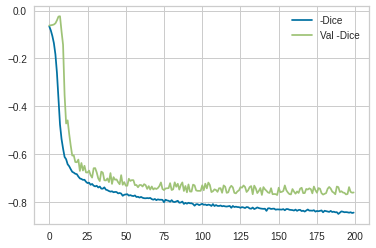

+++++++++++++++++++++++++++++++++++++
[0. 1.]
+++++++++++++++++++++++++++++++++++++


In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 1
# phi_units = 16
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for phi_units in [128]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    print('File exists')

  tf.keras.backend.clear_session()

  seg_model = fcn((height,width),phi_units,ch_out=3)

  seg_model.compile(optimizer=Adam(lr=1e-4),
                    loss={'output':dice_coef_loss},
                    metrics = metrics)

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  # test_t = df_test_images['nerve_name'].to_list()
  template = 'there is nerve: {}\t Dice: {}\t AUC: {}'
  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  there_is_nerve = []
  show = True
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = cv2.resize(cv2.imread(path_file),(height,width))
    mask = cv2.resize(cv2.imread(mask_file,0),(height,width)).reshape(-1,)
    if mask.sum()==0:
      there_is_nerve.append(False)
    else:
      there_is_nerve.append(True)
      mask = mask/mask.max()
      mask[mask >= 0.5] = 1.
      mask[mask <0.5] = 0.
      if show:
        print('+++++++++++++++++++++++++++++++++++++')
        print(np.unique(mask))
        print('+++++++++++++++++++++++++++++++++++++')
        show = False
    # print(np.unique(mask))
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1,zero_division=0))
    try:
      AUC.append(roc_auc_score(mask,mask_est))
    except:
      AUC.append('null')

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.savefig(basepath+'/Boxplot_all')
  # plt.show()

  # for name_nerve in ['ciatico','cubital','femoral','mediano']:
  #   Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  #   AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  # plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  # plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  # plt.title(name_nerve)
  # plt.savefig(basepath+'/Boxplot')
  # plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results results* results.xlsx

  adding: results_a-1_phi-units-128/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/keras_metadata.pb (deflated 94%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.index (deflated 76%)
  adding: results_a-1_phi-units-128/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: results_a-1_phi-units-128/LearningCurve.png (deflated 4%)
  adding: results_a-1_phi-units-128/results.joblib (deflated 70%)
  adding: results_a-1_phi-units-128/model.h5 (deflated 8%)
  adding: results.xlsx (deflated 2%)


In [ ]:
from google.colab import files
files.download('results.xlsx')
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp results.zip ./gdrive/MyDrive/